# Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from pep_modules import patientai as pai

In [2]:
def plot_roc_curve(y_true, y_score, roc_auc_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(10,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Loading data

In [3]:
cross_df = pd.read_pickle(r'../data/cross_data.pkl')
targets_df = pd.read_pickle(r'../data/target.pkl')

x_train_static = pd.read_pickle(r'../data/train_static.pkl')
x_val_static = pd.read_pickle(r'../data/val_static.pkl')
x_test_static = pd.read_pickle(r'../data/test_static.pkl')

In [4]:
print(cross_df.shape)
cross_df.head()

(45980, 4)


,pat_id,journey,event_day,marked_journey
0,2,"[NEO*IV*Gentamicin, Syringe (Neonatal) *D5W*, ...","[1, 2, 3, 4, 5, 6, 7, 8]","[NEO*IV*Gentamicin, Syringe (Neonatal) *D5W*, ..."
1,3,"[966.0, 3893.0, 9672.0, 8964.0, 9962.0, 9604.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[966.0, 3893.0, 9672.0, 8964.0, 9962.0, 9604.0..."
2,4,"[D5W, Vancomycin HCl, Potassium Chloride, Insu...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[D5W, Vancomycin HCl, Potassium Chloride, Insu..."
3,5,"[9955.0, V290, V053, V3000]","[1, 2, 3, 4]","[9955.0, V290, V053, V3000]"
4,6,"[Tacrolimus, Tacrolimus, Valganciclovir HCl, W...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[Tacrolimus, Tacrolimus, Valganciclovir HCl, W..."


In [5]:
# CLass imbalance
targets_df.switch_flag.sum()*100/len(targets_df)

3.357981731187473

In [6]:
X1, X_test, y1, y_test = train_test_split(cross_df, targets_df, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.15, random_state=42)

# Best Results

In [7]:
# best parameters without and with static features
w2v_dim_static = 64
jlen_static = 120

w2v_dim = 64
jlen = 120

## Without static 

In [8]:
loaded_word2vec = Word2Vec.load(f'../saved_models/word2vec_{w2v_dim}.model')

In [9]:
x_train_tensor, y_train_tensor = pai.get_all_tensors_deepr(X_train,'journey',
                                                                 y_train,'switch_flag',loaded_word2vec,jlen)
x_val_tensor, y_val_tensor = pai.get_all_tensors_deepr(X_val,'journey',
                                                             y_val,'switch_flag',loaded_word2vec,jlen)
x_test_tensor, y_test_tensor = pai.get_all_tensors_deepr(X_test,'journey',
                                                               y_test,'switch_flag',loaded_word2vec,jlen)

x_train_tensor = np.squeeze(x_train_tensor)
x_val_tensor = np.squeeze(x_val_tensor)
x_test_tensor = np.squeeze(x_test_tensor)

x_train_tensor = x_train_tensor.transpose((0,2,1))
x_val_tensor = x_val_tensor.transpose((0,2,1))
x_test_tensor = x_test_tensor.transpose((0,2,1))

print(x_train_tensor.shape, x_val_tensor.shape, x_test_tensor.shape)

(31266, 120, 64) (5518, 120, 64) (9196, 120, 64)


In [10]:
model = pai.build_rnn(jlen, w2v_dim)

In [11]:
es_callback = callbacks.EarlyStopping(monitor='val_my_auc', patience=5, mode='max',restore_best_weights=True)
model.fit(x_train_tensor,y_train_tensor, epochs=100, callbacks=[es_callback], validation_data=(x_val_tensor,y_val_tensor))
model.save_weights('../saved_models/simple_rnn.h5')

Train on 31266 samples, validate on 5518 samples
Epoch 1/100
31266/31266 [==============================] - 75s 2ms/sample - loss: 0.1529 - my_auc: 0.5159 - val_loss: 0.1644 - val_my_auc: 0.5364
Epoch 2/100
31266/31266 [==============================] - 86s 3ms/sample - loss: 0.1431 - my_auc: 0.5665 - val_loss: 0.1669 - val_my_auc: 0.5387
Epoch 3/100
31266/31266 [==============================] - 87s 3ms/sample - loss: 0.1414 - my_auc: 0.5692 - val_loss: 0.1661 - val_my_auc: 0.4782
Epoch 4/100
31266/31266 [==============================] - 81s 3ms/sample - loss: 0.1403 - my_auc: 0.5862 - val_loss: 0.1665 - val_my_auc: 0.5058
Epoch 5/100
31266/31266 [==============================] - 87s 3ms/sample - loss: 0.1376 - my_auc: 0.6206 - val_loss: 0.1699 - val_my_auc: 0.4990
Epoch 6/100
31266/31266 [==============================] - 95s 3ms/sample - loss: 0.1352 - my_auc: 0.6329 - val_loss: 0.1702 - val_my_auc: 0.5026
Epoch 7/100
31266/31266 [==============================] - 94s 3ms/sample -

In [12]:
trn_result = model.evaluate(x_train_tensor,y_train_tensor)

31266/31266 [==============================] - 17s 531us/sample - loss: 0.1397 - my_auc: 0.5828


In [13]:
val_results = model.evaluate(x_val_tensor,y_val_tensor)

5518/5518 [==============================] - 3s 587us/sample - loss: 0.1669 - my_auc: 0.5387


In [14]:
test_results = model.evaluate(x_test_tensor,y_test_tensor)
y_test_pred = model.predict(x_test_tensor)

9196/9196 [==============================] - 5s 520us/sample - loss: 0.1538 - my_auc: 0.5650


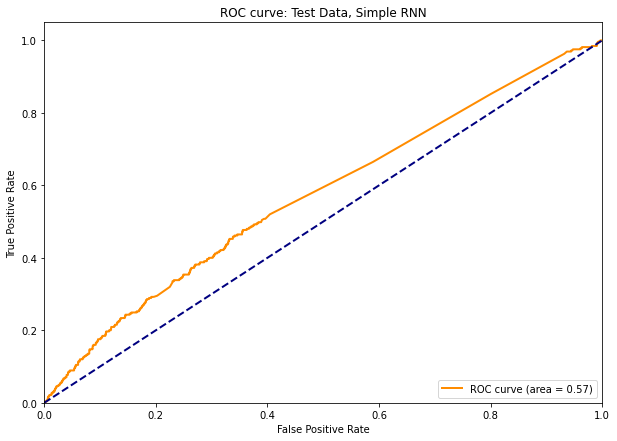

In [15]:
plot_roc_curve(y_test_tensor, y_test_pred, test_results[1], 'ROC curve: Test Data, Simple RNN')

## With static

In [16]:
loaded_word2vec = Word2Vec.load(f'../saved_models/word2vec_{w2v_dim_static}.model')

In [17]:
x_train_tensor, y_train_tensor = pai.get_all_tensors_deepr(X_train,'journey',
                                                                 y_train,'switch_flag',loaded_word2vec,jlen_static)
x_val_tensor, y_val_tensor = pai.get_all_tensors_deepr(X_val,'journey',
                                                             y_val,'switch_flag',loaded_word2vec,jlen_static)
x_test_tensor, y_test_tensor = pai.get_all_tensors_deepr(X_test,'journey',
                                                               y_test,'switch_flag',loaded_word2vec,jlen_static)

x_train_tensor = np.squeeze(x_train_tensor)
x_val_tensor = np.squeeze(x_val_tensor)
x_test_tensor = np.squeeze(x_test_tensor)

x_train_tensor = x_train_tensor.transpose((0,2,1))
x_val_tensor = x_val_tensor.transpose((0,2,1))
x_test_tensor = x_test_tensor.transpose((0,2,1))

print(x_train_tensor.shape, x_val_tensor.shape, x_test_tensor.shape)

(31266, 120, 64) (5518, 120, 64) (9196, 120, 64)


In [18]:
model = pai.build_rnn(jlen_static, w2v_dim_static, n_static=182)

In [23]:
es_callback = callbacks.EarlyStopping(monitor='val_my_auc', patience=5, mode='max',restore_best_weights=True)
model.fit([x_train_tensor,x_train_static],y_train_tensor, epochs=100, callbacks=[es_callback], validation_data=([x_val_tensor, x_val_static],y_val_tensor))
model.save_weights('../saved_models/static_simple_rnn.h5')

Train on 31266 samples, validate on 5518 samples
Epoch 1/100
31266/31266 [==============================] - 71s 2ms/sample - loss: 0.1480 - my_auc: 0.5715 - val_loss: 0.1618 - val_my_auc: 0.6509
Epoch 2/100
31266/31266 [==============================] - 83s 3ms/sample - loss: 0.1379 - my_auc: 0.6604 - val_loss: 0.1629 - val_my_auc: 0.6631
Epoch 3/100
31266/31266 [==============================] - 84s 3ms/sample - loss: 0.1352 - my_auc: 0.6908 - val_loss: 0.1586 - val_my_auc: 0.6659
Epoch 4/100
31266/31266 [==============================] - 91s 3ms/sample - loss: 0.1348 - my_auc: 0.6979 - val_loss: 0.1677 - val_my_auc: 0.6892: 0.1352 - my_a
Epoch 5/100
31266/31266 [==============================] - 105s 3ms/sample - loss: 0.1311 - my_auc: 0.7321 - val_loss: 0.1577 - val_my_auc: 0.6882
Epoch 6/100
31266/31266 [==============================] - 120s 4ms/sample - loss: 0.1265 - my_auc: 0.7675 - val_loss: 0.1622 - val_my_auc: 0.6735
Epoch 7/100
31266/31266 [==============================] -

In [24]:
trn_result = model.evaluate([x_train_tensor,x_train_static],y_train_tensor)

31266/31266 [==============================] - 32s 1ms/sample - loss: 0.1338 - my_auc: 0.7624


In [25]:
val_results = model.evaluate([x_val_tensor, x_val_static],y_val_tensor)

5518/5518 [==============================] - 5s 835us/sample - loss: 0.1677 - my_auc: 0.6892


In [26]:
test_results = model.evaluate([x_test_tensor,x_test_static],y_test_tensor)
y_test_pred = model.predict([x_test_tensor,x_test_static])

9196/9196 [==============================] - 8s 916us/sample - loss: 0.1543 - my_auc: 0.6885


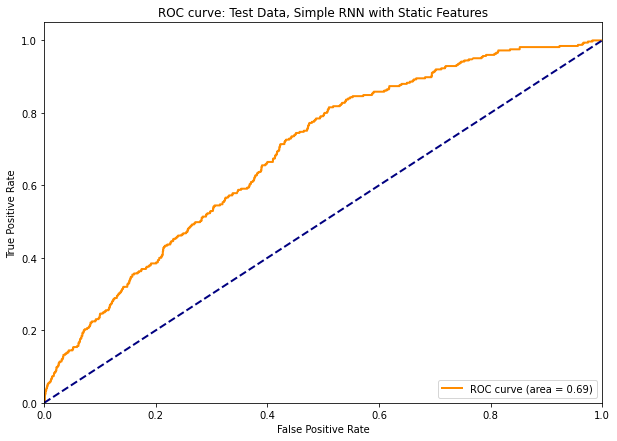

In [29]:
plot_roc_curve(y_test_tensor, y_test_pred, test_results[1], 'ROC curve: Test Data, Simple RNN with Static Features')